In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
# device = torch.device('cuda:0'
#                       if torch.cuda.is_available()
#                       else 'cpu')
device = torch.device('cpu')
print(device)
print(torch.__version__)#1.6.0

cpu
1.6.0


In [3]:
IMG_PATH = 'img/cake.jpg'
BATCH_SIZE = 4096

In [4]:
class Image(Dataset):
    def __init__(self, img_path):
        img = plt.imread(img_path)
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        if np.max(img) <= 1:
            img *= 255
            img = img.astype(np.uint8)
        h, w, c = img.shape
        img = cv2.resize(img, (500, int(500*h/w)))
        h, w, c = img.shape
        img = img.astype(np.float)
        img /= np.max(img)
        yx = np.mgrid[0:1:1./h, 0:1:1./w].reshape(2, -1).T
        color = img.reshape(-1, 3)
        self.data = torch.from_numpy(yx).to(device)
        self.t = torch.from_numpy(color).to(device)
    
    def __getitem__(self, index):
        return self.data[index], self.t[index]
    
    def __len__(self):
        return len(self.data)

In [5]:
dataset = Image(IMG_PATH)
batch_size = BATCH_SIZE
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle = True)
loop = len(dataloader)

/mnt/nfs/kawanan/anaconda3/envs/COIN/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [7]:
class Dense(nn.Module):
    
    def __init__(self, input_dim, output_dim, activation=lambda x: x):
        super().__init__()
        
        self.W = nn.Parameter(
            torch.Tensor(
                np.random.normal(
                    size=(input_dim, output_dim)
                )
            )
        )
        self.b = nn.Parameter(
            torch.Tensor(
                np.zeros(output_dim)
            )
        )
        self.activation = activation
        
    def forward(self, x):
        #print(x.device, self.W.device, self.b.device)
        return self.activation(torch.matmul(x, self.W) + self.b)

In [8]:
def mish(x):
    return x * torch.tanh(F.softplus(x))
class YX2COLOR(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=100):
        super().__init__()
        self.layer1 = Dense(input_dim, hidden_dim, activation= torch.tanh)
        self.layer2 = Dense(hidden_dim, hidden_dim, activation=torch.tanh)
        self.layer3 = Dense(hidden_dim, hidden_dim, activation=torch.tanh)
        self.layer4 = Dense(hidden_dim, hidden_dim, activation=torch.tanh)
        self.layer5 = Dense(hidden_dim, output_dim, activation=torch.sigmoid)
    
    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)
        return output

In [9]:
print('default image(H*W*C):\t', len(dataset)*3)
hidden_dim = int((len(dataset)/100)**0.5)
model = YX2COLOR(2, 3, hidden_dim=hidden_dim).to(device)
#if torch.cuda.is_available():
#    model = torch.nn.DataParallel(model) 
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print('model param count:\t', params)

default image(H*W*C):	 562500
model param count:	 5937


In [10]:
criterion = nn.MSELoss()
lr = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
def compute_loss(t, y):
    return criterion(t, y)

def train_step(x, t):
    model.train()
    y = model(x)
    loss = compute_loss(t, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, y

In [11]:
epochs = 100
for epoch in range(epochs):
    train_loss = 0.
    
    for i, (X_batch, y_batch) in enumerate(dataloader):
        print('\r', str(int(i*100/loop))+'%', end='')
        loss, y = train_step(X_batch.float(), y_batch.float())
        train_loss += loss.item()
    print()
        
    if epoch % 1 == 0 or epoch == epochs - 1:
        print('epoch: {}, loss: {:.3}'.format(
            epoch + 1,
            train_loss,
        ))

 97%
epoch: 1, loss: 7.34
 97%
epoch: 2, loss: 5.36
 97%
epoch: 3, loss: 4.16
 97%
epoch: 4, loss: 3.28
 97%
epoch: 5, loss: 3.04
 97%
epoch: 6, loss: 2.88
 97%
epoch: 7, loss: 2.78
 97%
epoch: 8, loss: 2.69
 97%
epoch: 9, loss: 2.6
 97%
epoch: 10, loss: 2.5
 97%
epoch: 11, loss: 2.42
 97%
epoch: 12, loss: 2.38
 97%
epoch: 13, loss: 2.34
 97%
epoch: 14, loss: 2.31
 97%
epoch: 15, loss: 2.27
 97%
epoch: 16, loss: 2.28
 97%
epoch: 17, loss: 2.25
 97%
epoch: 18, loss: 2.21
 97%
epoch: 19, loss: 2.2
 97%
epoch: 20, loss: 2.16
 97%
epoch: 21, loss: 2.15
 97%
epoch: 22, loss: 2.15
 97%
epoch: 23, loss: 2.13
 97%
epoch: 24, loss: 2.11
 97%
epoch: 25, loss: 2.09
 97%
epoch: 26, loss: 2.09
 97%
epoch: 27, loss: 2.07
 97%
epoch: 28, loss: 2.06
 97%
epoch: 29, loss: 2.06
 97%
epoch: 30, loss: 2.05
 97%
epoch: 31, loss: 2.03
 97%
epoch: 32, loss: 2.03
 97%
epoch: 33, loss: 2.02
 97%
epoch: 34, loss: 2.0
 97%
epoch: 35, loss: 2.0
 97%
epoch: 36, loss: 1.98
 97%
epoch: 37, loss: 1.98
 97%
epoch: 38,

(1000000, 3)


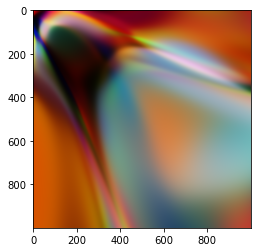

In [12]:
YX = torch.from_numpy(
    np.mgrid[0:1:1./1000, 0:1:1./1000].reshape(2, -1).T
).float().to(device)

s = model(YX).to('cpu').detach().numpy()
print(s.shape)
s = s.reshape(1000, 1000, 3)
plt.imshow(s)

/mnt/nfs/kawanan/anaconda3/envs/COIN/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


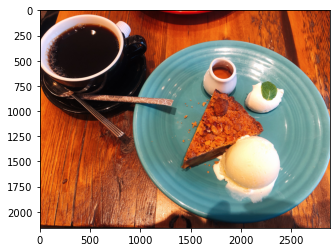

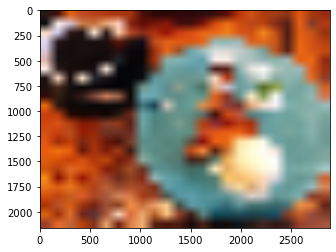

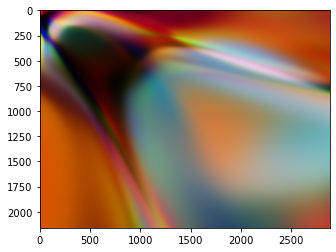

In [13]:
origin = plt.imread(IMG_PATH)
if origin.shape[2] == 4:
    origin = cv2.cvtColor(origin, cv2.COLOR_RGBA2RGB)
origin = origin.astype(np.float)
origin /= np.max(origin)
plt.imshow(origin)
plt.show()
img = cv2.resize(origin, (int(hidden_dim/(3**0.5)), int(hidden_dim/(3**0.5))))
#H*W*C=Parameter数になるよう（大体）に圧縮
img = cv2.resize(img, (origin.shape[1], origin.shape[0]))
img /= np.max(img)
plt.imshow(img)
plt.show()
s = cv2.resize(s, (origin.shape[1], origin.shape[0]))
plt.imshow(s)
plt.show()

In [14]:
img_rmse = (np.sum((img-origin)**2)/(origin.shape[0]*origin.shape[1]))**0.5
print('img_rmse:\t', img_rmse)
s_rmse = (np.sum((s-origin)**2)/(origin.shape[0]*origin.shape[1]))**0.5
print('model_rmse:\t', s_rmse)

img_rmse:	 0.26169434302482364
model_rmse:	 0.32614527877302907
